In [74]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [62]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [3]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/hcp/")
hcp_data_dict = np.load(data_dir/"hcp_data_dict.npy", allow_pickle=True).item()
brain_networks = hcp_data_dict["network"] / count_offset
traits = hcp_data_dict["cog"][:,4] 
avg_trans = np.nanmean(hcp_data_dict["trans"], -1)
avg_rotat = np.nanmean(hcp_data_dict["rotat"], -1)

nan_mask = np.argwhere(~np.isnan(traits))
brain_networks = brain_networks[nan_mask]
traits = traits[nan_mask]
avg_trans = avg_trans[nan_mask]
avg_rotat = avg_rotat[nan_mask]
n_subs = brain_networks.shape[0]

print(brain_networks.shape)
print(traits.shape)
print(avg_trans.shape)

(1061, 1, 68, 68)
(1061, 1)
(1061, 1)


In [4]:
motion = np.concatenate([avg_trans, avg_rotat], axis=-1)

In [5]:
sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_trans_ids = sub_ids[avg_trans > np.quantile(avg_trans, .9)]
big_rotat_ids = sub_ids[avg_rotat > np.quantile(avg_rotat, .9)]
small_trans_ids = sub_ids[avg_trans < np.quantile(avg_trans, .1)]
small_rotat_ids = sub_ids[avg_rotat < np.quantile(avg_rotat, .1)]

In [6]:
big_trans = avg_trans[big_trans_ids].reshape(-1,1)
small_trans = avg_trans[small_trans_ids].reshape(-1,1)
big_rotat = avg_rotat[big_rotat_ids].reshape(-1,1)
small_rotat = avg_rotat[small_rotat_ids].reshape(-1,1)

In [7]:
big_trans_nets = brain_networks[big_trans_ids].reshape(-1,n_rois*n_rois)
small_trans_nets = brain_networks[small_trans_ids].reshape(-1,n_rois*n_rois)
diff_trans_nets = big_trans_nets.mean(0) - small_trans_nets.mean(0)

big_rotat_nets = brain_networks[big_rotat_ids].reshape(-1,n_rois*n_rois)
small_rotat_nets = brain_networks[small_rotat_ids].reshape(-1,n_rois*n_rois)
diff_rotat_nets = big_rotat_nets.mean(0) - small_rotat_nets.mean(0)

In [79]:
pca = TSNE(2)
obs_trans_Xt = pca.fit_transform(np.vstack([big_trans_nets, small_trans_nets]))
obs_trans_df = pd.DataFrame({"pc1": obs_trans_Xt[:,0], 
                       "pc2": obs_trans_Xt[:,1],
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
obs_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_nets, small_rotat_nets]))
obs_rotat_df = pd.DataFrame({"pc1": obs_rotat_Xt[:,0], 
                       "pc2": obs_rotat_Xt[:,1],
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

In [9]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.,
    beta = .001, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [10]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [11]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

954 107


vae

In [12]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [13]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 8370.615 nll: -1503.142 kl: 477.414 rmse: 17.584
epoch: 0 test loss: -228.657 nll: -8169.004 kl: 915.789 rmse: 16.852
epoch: 5 train loss: -16573.745 nll: -16879.954 kl: 17066.223 rmse: 2.996
epoch: 5 test loss: -16795.440 nll: -17124.365 kl: 17559.145 rmse: 3.320
epoch: 10 train loss: -16630.111 nll: -16930.855 kl: 16926.015 rmse: 2.967
epoch: 10 test loss: -16841.340 nll: -17167.295 kl: 17225.121 rmse: 3.307
epoch: 15 train loss: -16646.759 nll: -16943.146 kl: 16807.695 rmse: 2.945
epoch: 15 test loss: -16855.887 nll: -17179.142 kl: 17074.186 rmse: 3.295
epoch: 20 train loss: -16656.690 nll: -16948.002 kl: 16711.365 rmse: 2.919
epoch: 20 test loss: -16863.645 nll: -17184.077 kl: 17073.834 rmse: 3.282
epoch: 25 train loss: -16665.037 nll: -16950.630 kl: 16737.101 rmse: 2.888
epoch: 25 test loss: -16868.511 nll: -17185.851 kl: 17112.913 rmse: 3.267
epoch: 30 train loss: -16672.964 nll: -16952.072 kl: 16590.947 rmse: 2.854
epoch: 30 test loss: -16874.984 nll: -17188

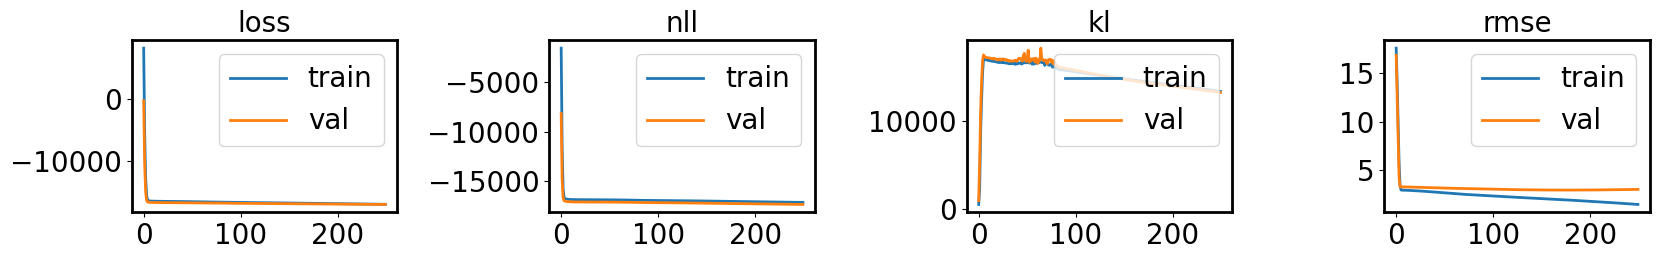

In [14]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [15]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_recon = x_recon*count_offset

In [16]:
big_trans_recon = x_recon[big_trans_ids]
small_trans_recon = x_recon[small_trans_ids]
diff_trans_recon = big_trans_recon.mean(0) - small_trans_recon.mean(0)

big_rotat_recon = x_recon[big_rotat_ids]
small_rotat_recon = x_recon[small_rotat_ids]
diff_rotat_recon = big_rotat_recon.mean(0) - small_rotat_recon.mean(0)

In [17]:
big_trans_latents = vae_latents[big_trans_ids]
small_trans_latents = vae_latents[small_trans_ids]
big_rotat_latents = vae_latents[big_rotat_ids]
small_rotat_latents = vae_latents[small_rotat_ids]

In [100]:
pca = TSNE(2)
vae_trans_Xt = pca.fit_transform(np.vstack([big_trans_latents, small_trans_latents]))
vae_trans_df = pd.DataFrame({"pc1": vae_trans_Xt[:,0], 
                       "pc2": vae_trans_Xt[:,1],
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
vae_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_latents, small_rotat_latents]))
vae_rotat_df = pd.DataFrame({"pc1": vae_rotat_Xt[:,0], 
                       "pc2": vae_rotat_Xt[:,1], 
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

inv-vae

In [19]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
    beta = 100., gamma = .1, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [20]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [21]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 10334.270 nll: -1376.138 kl: 584.599 inv_loss: 1.623 rmse: 17.980
epoch: 0 test loss 8144.343 nll: -7960.917 kl: 810.266 inv_loss: 1.608 rmse: 17.726
epoch: 5 train loss: -1246.025 nll: -16875.926 kl: 21708.248 inv_loss: 0.901 rmse: 3.301
epoch: 5 test loss -1145.411 nll: -17119.108 kl: 24111.200 inv_loss: 2.524 rmse: 3.324
epoch: 10 train loss: -1332.851 nll: -16925.420 kl: 24906.785 inv_loss: 0.762 rmse: 2.965
epoch: 10 test loss -1167.677 nll: -17162.815 kl: 25492.698 inv_loss: 2.378 rmse: 3.318
epoch: 15 train loss: -1351.398 nll: -16938.670 kl: 25109.033 inv_loss: 0.633 rmse: 2.942
epoch: 15 test loss -1188.707 nll: -17170.421 kl: 25691.140 inv_loss: 2.200 rmse: 3.306
epoch: 20 train loss: -1367.387 nll: -16943.516 kl: 25402.895 inv_loss: 0.529 rmse: 2.916
epoch: 20 test loss -1207.099 nll: -17176.445 kl: 26025.780 inv_loss: 2.054 rmse: 3.291
epoch: 25 train loss: -1381.294 nll: -16944.376 kl: 25829.553 inv_loss: 0.450 rmse: 2.884
epoch: 25 test loss -1222.956

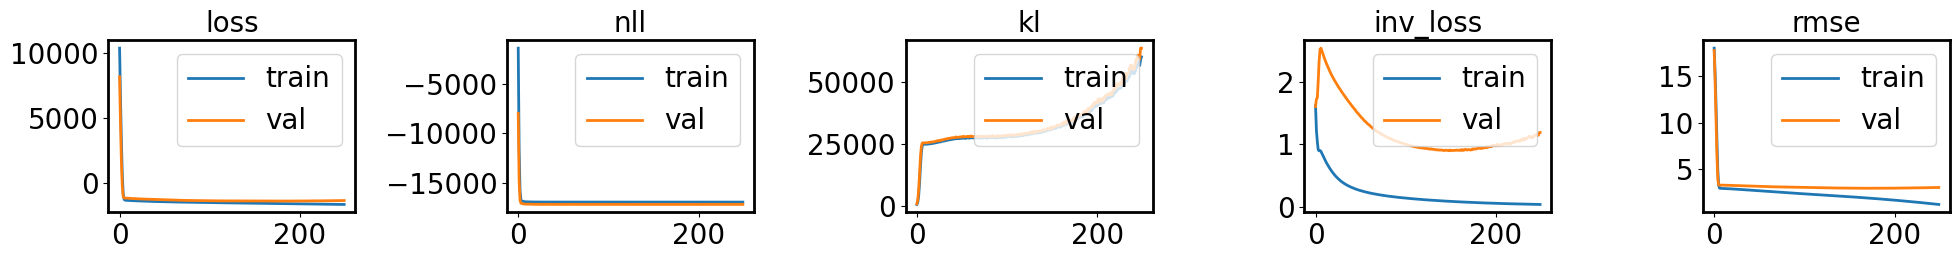

In [22]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [23]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()

x_denoised = inv_model.decode(z_sample, 
                      torch.zeros_like(tensor_motion).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_denoised = x_denoised*count_offset

In [24]:
big_trans_denoised = x_denoised[big_trans_ids]
small_trans_denoised = x_denoised[small_trans_ids]
diff_trans_denoised = big_trans_denoised.mean(0) - small_trans_denoised.mean(0)

big_rotat_denoised = x_denoised[big_rotat_ids]
small_rotat_denoised = x_denoised[small_rotat_ids]
diff_rotat_denoised = big_rotat_denoised.mean(0) - small_rotat_denoised.mean(0)

In [25]:
big_trans_inv_latents = inv_latents[big_trans_ids]
small_trans_inv_latents = inv_latents[small_trans_ids]
big_rotat_inv_latents = inv_latents[big_rotat_ids]
small_rotat_inv_latents = inv_latents[small_rotat_ids]

In [101]:
pca = TSNE(2)
inv_vae_trans_Xt = pca.fit_transform(np.vstack([big_trans_inv_latents, small_trans_inv_latents]))
inv_vae_trans_df = pd.DataFrame({"pc1": inv_vae_trans_Xt[:,0], 
                       "pc2": inv_vae_trans_Xt[:,1], 
                       "trans": np.vstack([big_trans, small_trans]).flatten()})
inv_vae_rotat_Xt = pca.fit_transform(np.vstack([big_rotat_inv_latents, small_rotat_inv_latents]))
inv_vae_rotat_df = pd.DataFrame({"pc1": inv_vae_rotat_Xt[:,0], 
                       "pc2": inv_vae_rotat_Xt[:,1],
                       "rotat": np.vstack([big_rotat, small_rotat]).flatten()})

plotting

In [89]:
n=39
x = 0.32 # 0.32
cmap = plt.cm.jet
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('div_cmap', colors)

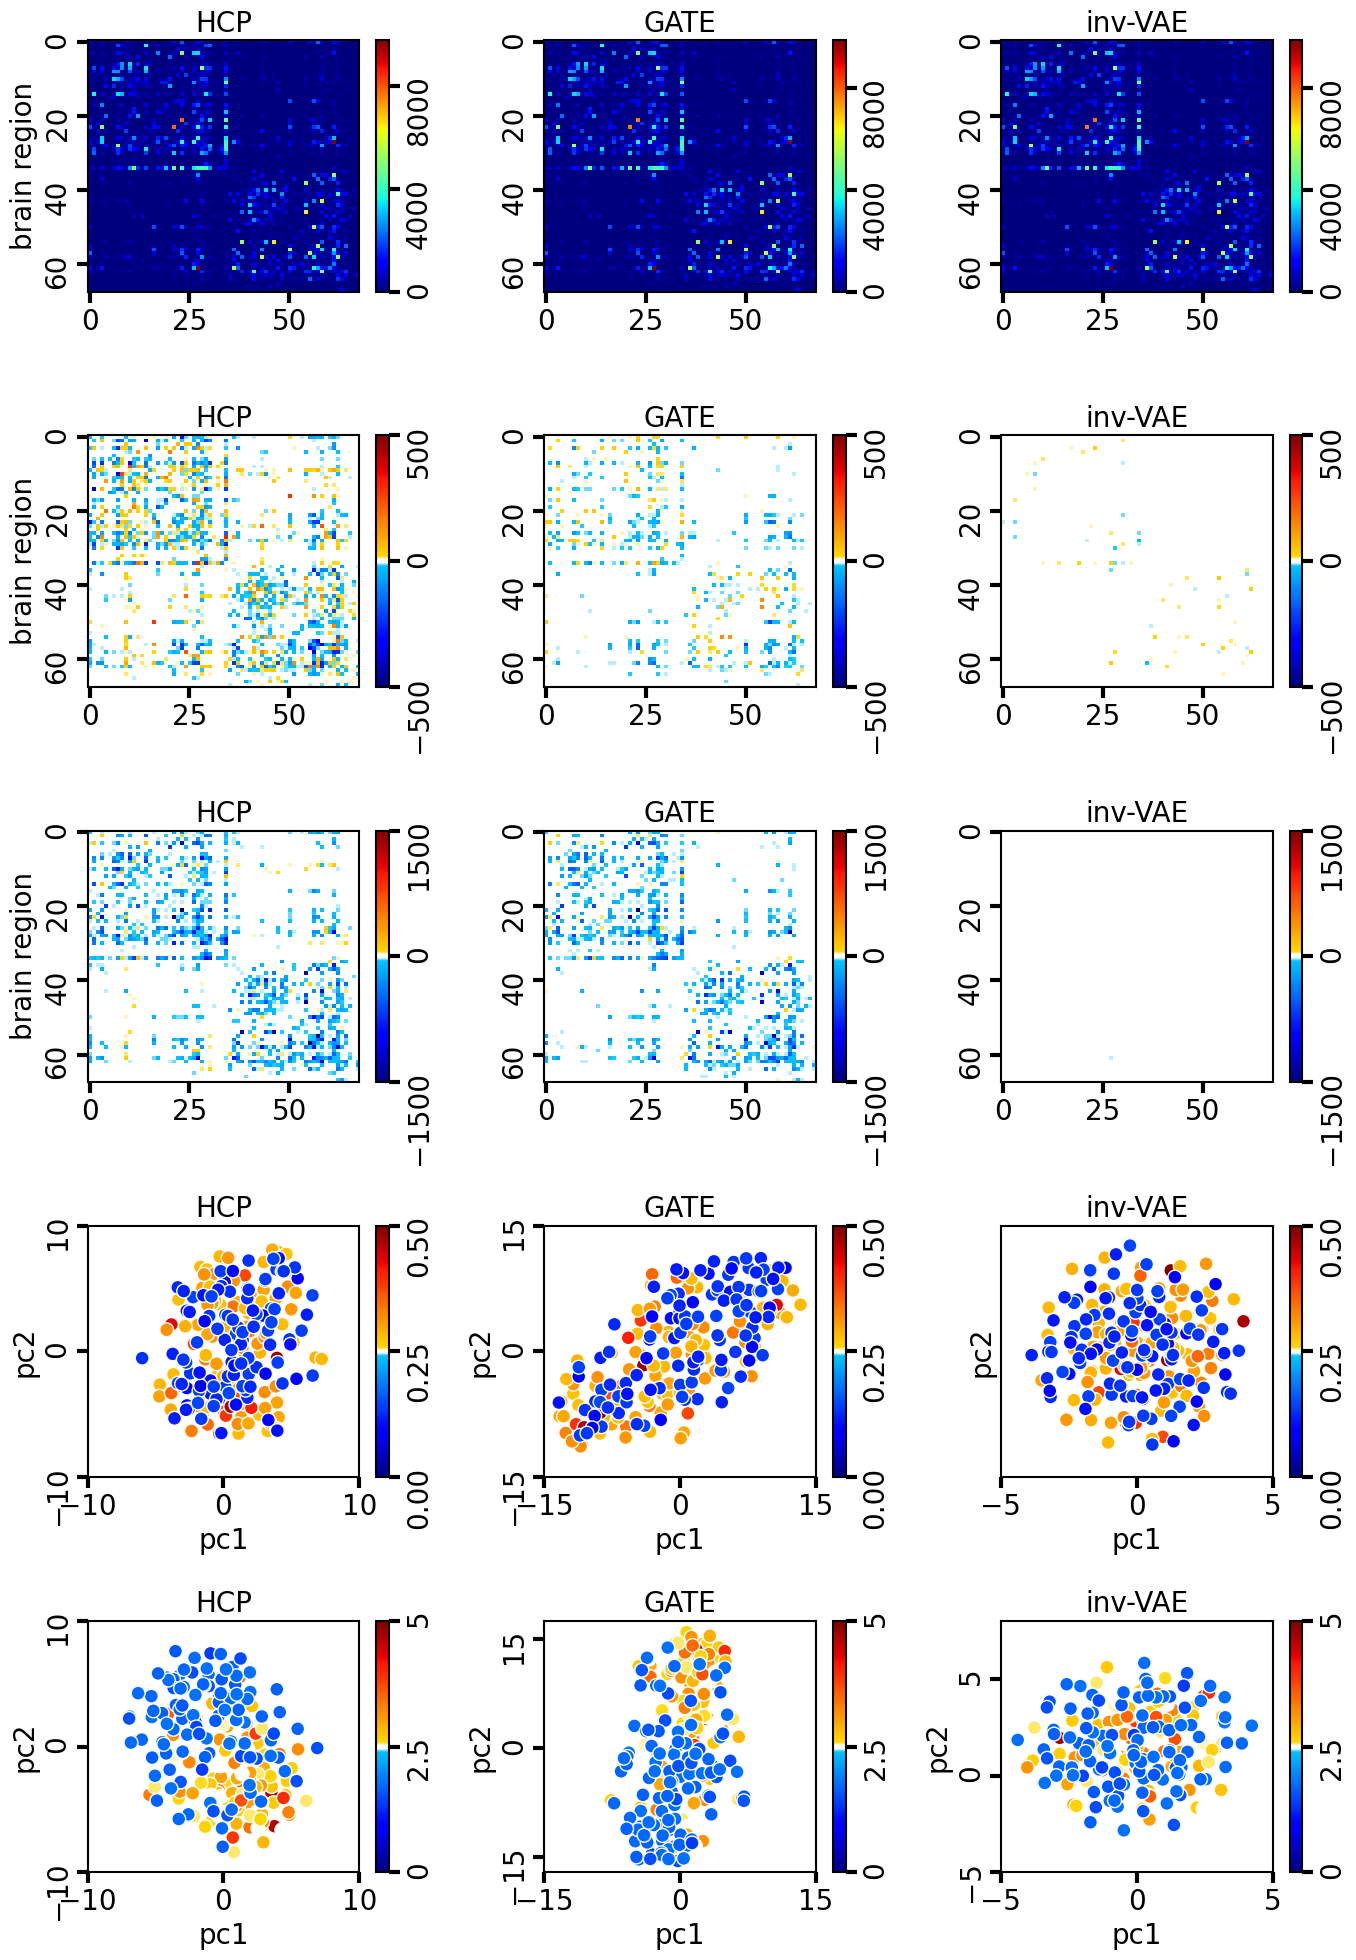

In [118]:
fig = plt.figure(figsize=(14, 20))

ax = fig.add_subplot(5, 3, 1)
p1 = ax.imshow(brain_networks.mean(0).reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap='jet')
ax.set_title('HCP')
ax.set_ylabel('brain region')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p1, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([0, 4000, 8000])

ax = fig.add_subplot(5, 3, 4)
p2 = ax.imshow(diff_trans_nets.reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap=div_cmap, vmin=-500, vmax=500)
ax.set_title('HCP')
ax.set_ylabel('brain region')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p2, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-500, 0, 500])

ax = fig.add_subplot(5, 3, 7)
p3 = ax.imshow(diff_rotat_nets.reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap=div_cmap, vmin=-1500, vmax=1500)
ax.set_title('HCP')
ax.set_ylabel('brain region')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p3, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-1500, 0, 1500])

ax = fig.add_subplot(5, 3, 10)
p4 = ax.scatter(obs_trans_df["pc1"], obs_trans_df["pc2"], c=obs_trans_df["trans"], cmap=div_cmap, 
                edgecolor="white", s=100, alpha=1., vmin=0, vmax=0.5)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
ax.set_title('HCP')
cbar = plt.colorbar(p4, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([0, 0.25, .5])
ax.set_yticks([-10, 0, 10])
ax.set_xticks([-10, 0, 10])
        
ax = fig.add_subplot(5, 3, 13)
p5 = ax.scatter(obs_rotat_df["pc1"], obs_rotat_df["pc2"], c=obs_rotat_df["rotat"], cmap=div_cmap, 
                edgecolor="white", s=100, alpha=1., vmin=0, vmax=0.005)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_title('HCP')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p5, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([0, 0.0025, .005])
cbar.set_ticklabels([0, 2.5, 5])
ax.set_yticks([-10, 0, 10])
ax.set_xticks([-10, 0, 10])

ax = fig.add_subplot(5, 3, 2)
p6 = ax.imshow(x_recon.mean(0), aspect='auto', cmap='jet')
ax.set_title('GATE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p6, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([0, 4000, 8000])

ax = fig.add_subplot(5, 3, 5)
p7 = ax.imshow(diff_trans_recon, aspect='auto', cmap=div_cmap, vmin=-500, vmax=500)
ax.set_title('GATE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p7, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-500, 0, 500])

ax = fig.add_subplot(5, 3, 8)
p8 = ax.imshow(diff_rotat_recon.reshape(n_rois,n_rois), 
               aspect='auto', cmap=div_cmap, vmin=-1500, vmax=1500)
ax.set_title('GATE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p8, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-1500, 0, 1500])

ax = fig.add_subplot(5, 3, 11)
p9 = ax.scatter(x="pc1", y="pc2", c="trans", cmap=div_cmap, 
                       data=vae_trans_df, s=100, edgecolor="white", alpha=1., vmin=0, vmax=0.5)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_title('GATE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p9, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([0, 0.25, .5])
ax.set_yticks([-15, 0, 15])
ax.set_xticks([-15, 0, 15])

ax = fig.add_subplot(5, 3, 14)
p10 = ax.scatter(x="pc1", y="pc2", c="rotat", cmap=div_cmap, 
                 data=vae_rotat_df, s=100, edgecolor="white", alpha=1., vmin=0, vmax=0.005)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_title('GATE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p10, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([0, 0.0025, .005])
cbar.set_ticklabels([0, 2.5, 5])
ax.set_yticks([-15, 0, 15])
ax.set_xticks([-15, 0, 15])

ax = fig.add_subplot(5, 3, 3)
p11 = ax.imshow(x_denoised.mean(0), aspect='auto', cmap='jet')
ax.set_title('inv-VAE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p11, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([0, 4000, 8000])

ax = fig.add_subplot(5, 3, 6)
p12 = ax.imshow(diff_trans_denoised, aspect='auto', cmap=div_cmap, vmin=-500, vmax=500)
ax.set_title('inv-VAE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p12, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-500, 0, 500])

ax = fig.add_subplot(5, 3, 9)
p13 = ax.imshow(diff_rotat_denoised.reshape(n_rois,n_rois), 
                      aspect='auto', cmap=div_cmap, vmin=-1500, vmax=1500)
ax.set_title('inv-VAE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p13, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([-1500, 0, 1500])

ax = fig.add_subplot(5, 3, 12)
p14 = ax.scatter(x="pc1", y="pc2", c="trans", cmap=div_cmap, 
                        data=inv_vae_trans_df, s=100, 
                        edgecolor="white", alpha=1., vmin=0, vmax=0.5)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_title('inv-VAE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p14, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
ax.set_yticks([-50, 250])
cbar.set_ticks([0, 0.25, .5])
ax.set_ylim(-5, 5)
ax.set_xlim(-5, 5)

ax = fig.add_subplot(5, 3, 15)
p15 = ax.scatter(x="pc1", y="pc2", c="rotat", cmap=div_cmap, 
                        data=inv_vae_rotat_df, s=100, 
                        edgecolor="white", alpha=1., vmin=0, vmax=0.005)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_title('inv-VAE')
ax.tick_params(axis='y', labelrotation=90, length=8, width=3)
ax.tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p15, ax=ax)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([0, 0.0025, .005])
cbar.set_ticklabels([0, 2.5, 5])
ax.set_ylim(-5, 8)
ax.set_xlim(-5, 5)

plt.tight_layout()
plt.savefig('../saved_figs/fig5_hcp_correct_motion.png', facecolor='white', dpi=800)

circular connectivity plots:

unfortunately, i am having trouble with plotting multiple circular connectivity plots using mne,\
so i have to plot each circ plot separately :(

In [29]:
cmap = plt.cm.tab20c

labels = {
    'bankssts': cmap(0),
    'caudalanteriorcingulate': cmap(1),
    'caudalmiddlefrontal': cmap(1),
    'cuneus': cmap(2),
    'entorhinal': cmap(3),
    'fusiform': cmap(4),
    'inferiorparietal': cmap(5),
    'inferiortemporal': cmap(5),
    'isthmuscingulate': cmap(6),
    'lateraloccipital': cmap(7),
    'lateralorbitofrontal': cmap(7),
    'lingual': cmap(8),
    'medialorbitofrontal': cmap(9),
    'middletemporal': cmap(10),
    'parahippocampal': cmap(11),
    'paracentral': cmap(11),
    'parsopercularis': cmap(11),
    'parsorbitalis': cmap(11),
    'parstriangularis': cmap(11),
    'pericalcarine': cmap(12),
    'postcentral': cmap(13),
    'posteriorcingulate': cmap(13),
    'precentral': cmap(14),
    'precuneus': cmap(14),
    'rostralanteriorcingulate': cmap(15),
    'rostralmiddlefrontal': cmap(15),
    'superiorfrontal': cmap(16),
    'superiorparietal': cmap(16),
    'superiortemporal': cmap(16),
    'supramarginal': cmap(16),
    'frontalpole': cmap(16),
    'temporalpole': cmap(17),
    'transversetemporal': cmap(18),
    'insula': cmap(19)
}

label_colors = list()
label_colors.extend(list(labels.values())[::-1])  
label_colors.extend(list(labels.values()))

lh_labels = ['lh-' + label for label in labels.keys()]
rh_labels = ['rh-' + label for label in labels.keys()]

node_order = list()
node_order.extend(lh_labels[::-1])  
node_order.extend(rh_labels)

node_angles = circular_layout(node_order, node_order, start_pos=90,
                              group_boundaries=[0, len(node_order) / 2])

In [30]:
diff_motion_adjusted = x_denoised.mean(0).flatten() - brain_networks.mean(0).reshape(-1, n_rois*n_rois)

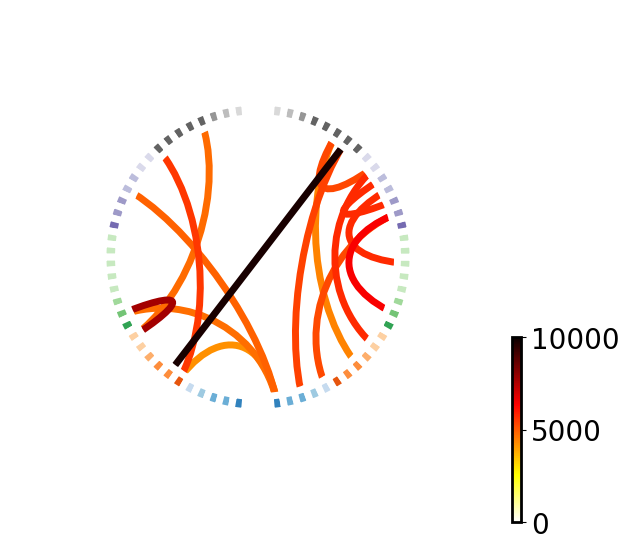

In [31]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white',
                       subplot_kw=dict(polar=True))
fig, ax = plot_connectivity_circle(
                         diff_motion_adjusted.reshape(n_rois,n_rois), 
                         node_angles=node_angles,
                         node_colors=label_colors,
                         facecolor='white',
                         textcolor='black', 
                         node_edgecolor='white',
                         colormap='hot_r',
                         node_height=1.,
                         node_linewidth=5.,
                         vmin=0,
                         vmax=1_0000,
                         node_names=['' for i in range(n_rois)], 
                         colorbar=True,
                         colorbar_size=.3,
                         fontsize_colorbar=20,
                         linewidth=5,
                         n_lines=15, ax=ax)
fig.tight_layout()
# fig.savefig('saved_figs/fig6_hcp_motion_adjusted.png', facecolor='white', dpi=400)